In [156]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tools.eval_measures import rmse

### Setup

In [157]:
import logging
logging.getLogger("cmdstanpy").disabled = True

In [158]:
colab = True
if colab:
    from google.colab import drive

    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [159]:
path = '/content/drive/MyDrive/Fall_2024_Capstone_Course_Project/' if colab else ''

In [160]:
!ls /content/drive/MyDrive/Fall_2024_Capstone_Course_Project/data/


CA_SMF.parquet	NC_CLT.parquet	TX_AUS.parquet	TX_IAH.parquet
csv		OK_TUL.parquet	TX_DFW.parquet	TX_SAT.parquet


### Data

In [161]:
df = pd.read_parquet(path + 'data/TX_AUS.parquet')
df = df.reset_index()
df = df.rename(columns={'invoice_date': 'ds', 'sale_value': 'y'})
df

,ds,y
0,2018-01-02,36191
1,2018-01-03,43787
2,2018-01-04,48195
3,2018-01-05,44204
4,2018-01-06,31278
...,...,...
1407,2021-11-09,52981
1408,2021-11-10,49062
1409,2021-11-11,51515
1410,2021-11-12,81668


### Daily

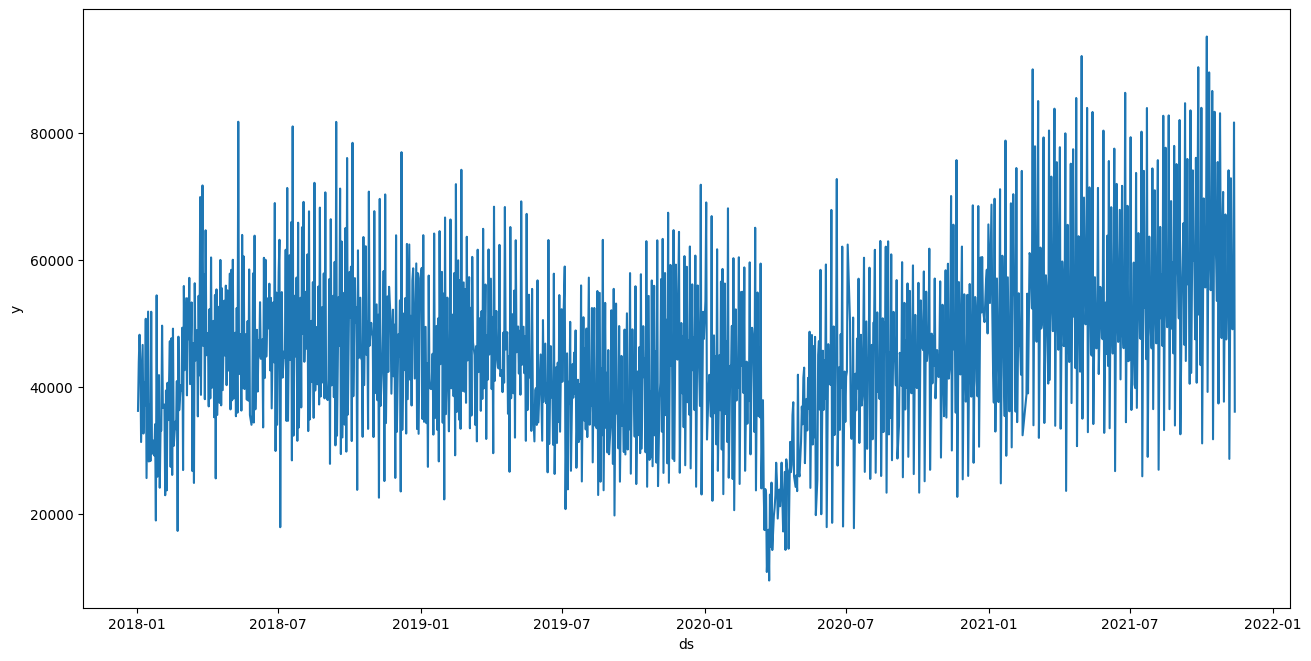

In [181]:
# Configure plot
fig, ax = plt.subplots(figsize=(13, 6.5), layout='constrained')
plt.xlabel('ds')
plt.ylabel('y')

# Plot the dataset
plt.plot(df['ds'], df['y'])

# Display the plot
plt.show()

In [163]:
df['ds'].describe(include='all')

,ds
count,1412
mean,2019-12-08 12:00:00
min,2018-01-02 00:00:00
25%,2018-12-20 18:00:00
50%,2019-12-08 12:00:00
75%,2020-11-25 06:00:00
max,2021-11-13 00:00:00


In [164]:
split = pd.Timestamp("2020-11-25")
train, test = df[df['ds'] < split], df[df['ds'] >= split]

In [165]:
model_daily = Prophet(daily_seasonality=False)
model_daily = model_daily.fit(train)
future = model_daily.make_future_dataframe(periods=len(test))
prediction_daily = model_daily.predict(future)
plot_plotly(model_daily, prediction_daily)

In [166]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


In [167]:
model_daily2 = Prophet(daily_seasonality=False, holidays=lockdowns)
model_daily2 = model_daily2.fit(train)
future2 = model_daily2.make_future_dataframe(periods=len(test))
prediction_daily2 = model_daily2.predict(future2)
plot_plotly(model_daily2, prediction_daily2)

### Weekly

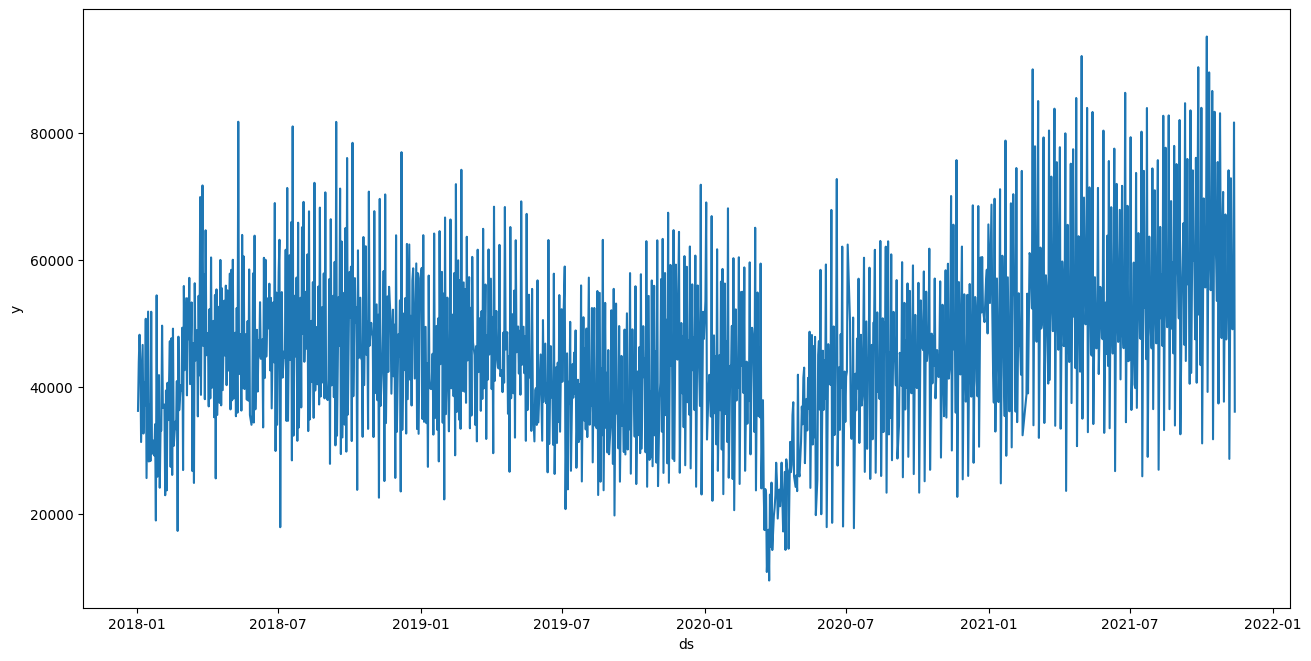

In [182]:
# Aggregate by weekly mean
dt = df.copy()
dt = dt.set_index('ds')
dt = dt['y'].resample('W').mean()
dt = dt.reset_index()

# Configure plot
fig, ax = plt.subplots(figsize=(13, 6.5), layout='constrained')
plt.xlabel('ds')
plt.ylabel('y')

# Plot the dataset
plt.plot(df['ds'], df['y'])

# Display the plot
plt.show()

In [169]:
dt.describe(include='all')

,ds,y
count,202,202.000000
mean,2019-12-11 12:00:00,45726.752475
min,2018-01-07 00:00:00,17245.142857
25%,2018-12-24 18:00:00,41455.214286
50%,2019-12-11 12:00:00,45983.428571
75%,2020-11-27 06:00:00,49399.750000
max,2021-11-14 00:00:00,63631.000000
std,NaN,7527.118748


In [170]:
split = pd.Timestamp('2020-11-27 06:00:00')
train, test = dt[dt['ds'] < split], dt[dt['ds'] >= split]

In [171]:
model_weekly = Prophet(daily_seasonality=False)
model_weekly.fit(train)
future = model_weekly.make_future_dataframe(periods=len(test))
prediction_weekly = model_weekly.predict(future)
plot_plotly(model_weekly, prediction_weekly)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [172]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


In [173]:
model_weekly2 = Prophet(daily_seasonality=False, holidays=lockdowns)
model_weekly2 = model_weekly2.fit(train)
future2 = model_weekly2.make_future_dataframe(periods=len(test))
prediction_weekly2 = model_weekly2.predict(future2)
plot_plotly(model_weekly2, prediction_weekly2)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


### Evaluation

In [194]:
def calculate_aic(model, prediction):
    # Calculate residuals
    test['yhat'] = prediction['yhat'][-len(test):].values
    test['residuals'] = test['y'] - test['yhat']

    # Calculate log-likelihood
    sigma2 = np.var(test['residuals'])
    n = len(test)
    log_likelihood = -n/2 * (np.log(2 * np.pi * sigma2) + 1)

    # Estimate number of parameters (k)
    k = len(model.params)

    # Calculate AIC
    AIC = 2 * k - 2 * log_likelihood

    return AIC

RMSE_daily = rmse(prediction_daily['yhat'][-len(test):], test['y'])
RMSE_daily2 = rmse(prediction_daily2['yhat'][-len(test):], test['y'])
RMSE_weekly = rmse(prediction_weekly['yhat'][-len(test):], test['y'])
RMSE_weekly2 = rmse(prediction_weekly2['yhat'][-len(test):], test['y'])

AIC_daily = calculate_aic(model_daily, prediction_daily)
AIC_daily2 = calculate_aic(model_daily2, prediction_daily2)
AIC_weekly = calculate_aic(model_weekly, prediction_weekly)
AIC_weekly2 = calculate_aic(model_weekly2, prediction_weekly2)

In [202]:
AIC = [AIC_daily, AIC_daily2, AIC_weekly, AIC_weekly2]
RMSE = [RMSE_daily, RMSE_daily2, RMSE_weekly, RMSE_weekly2]
rows = ['daily', 'daily2', 'weekly', 'weekly2']
AIC = [f'{i:.2f}' for i in AIC]
RMSE = [f'{i:.2f}' for i in RMSE]

In [214]:
AIC_max = len(max(AIC, key=lambda x: len(x)))
RMSE_max = len(max(RMSE, key=lambda x: len(x)))
separator_len = AIC_max + RMSE_max + 3
print(f'{"AIC":^{AIC_max}} | {"RMSE":^{RMSE_max}}')
print('-'*separator_len)
for name, aic, rmse in zip(rows, AIC, RMSE):
    print(f'{aic:>{AIC_max}} | {rmse:>{RMSE_max}}')

  AIC   |   RMSE  
------------------
1099.81 | 11857.16
1104.91 | 12320.65
1042.96 | 14605.49
1025.48 |  9012.19
